In [268]:
# sara Ghavampour 98 127 62 781

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Vs1KXtuIi7oGEcdeo-ZyCyoa-VxYzSbS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Vs1KXtuIi7oGEcdeo-ZyCyoa-VxYzSbS" -O pics.zip && rm -rf /tmp/cookies.txt

In [ ]:
!unzip pics.zip

In [271]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import PIL
import cv2
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
from sklearn.metrics.cluster import rand_score
import numpy as np
from collections import Counter
sns.set_style('darkgrid')

In [272]:
no_clusters=41

<div dir='rtl'>
<h2>
ساخت دیتاست و لیبل ها
</h2>
</div> 
<hr/>


<div dir='rtl'>
از ۱ شروع کرده و تا مضرب ۱۰ ان را از روی فایل های عکس ها به ترتیب خوانده و لیبل ان هارا ۱ قرار میدهیم و همینطور به طوری که برای مثال برای ۴۰۰ تا ۴۱۰ لیبل ۴۱ را قرار میدهیم. دراقع به همان ترتیب خود عکس ها در پوشه و لیبل هایشان ذخیره میکنیم. و عکس هارا flatten کرده و در ارایه نامپای ذحیره میکنیم. 
</div> 


In [273]:
from copy import deepcopy
import glob
from PIL import Image
root_dir='/content/'
grayscale_array = []

for i in range(1,42):
  for filename in glob.iglob(root_dir +'*_'+str(i) +'.jpg', recursive=True):
    img=cv2.imread(filename, 0)
    grayscale_array.append(img.flatten())
   


pics_array=np.array(grayscale_array)
pics_array_tmp=deepcopy(pics_array)  ## temp of imgs (410, 5600)

#pics_array.shape  (410, 5600)


<div dir='rtl'>
<h2>
ایجاد ارایه لیبل های درست
</h2>
</div> 
<hr/>


<div dir='rtl'>
ground_labels لیبل های اصلی و درست داده ها میباشد.
</div> 


In [274]:
# construct ground(true) labels   -> we read data in order-> so 10 first data have label 1 ,10 forthy-one data have label 41
ground_labels=[]
for i in range(0,no_clusters):
  x=[i+1 for j in range(10)]
  ground_labels.append(x)
  
ground_labels=np.array(ground_labels).reshape((410))
#ground_labels

<div dir='rtl'>
<h2>
تابع rand_index ( )
</h2>
</div> 
<hr/>


<div dir='rtl'>
ابتدا  تعداد کل زوج های دوتایی را حساب شده.سپس با استفاده از دیکشنری که کلید ان لیبل و مقدار ان تعداد اعضا کلاستر با ان لیبل میباشد,تعدادزوج های دوتایی داخل کلاستر ها را محاسبه میشود(p).سپس به صورت ۱۰ تا ۱۰ تا روی لیبل یک کانتر قرار میگیرد که مشخص شود هر کدام از این ۱۰ داده در چه کلاستر هایی قرار گرفته اند. و چون دیتا ست را به صورتی تشکیل دادیم که ۱۰ تا ۱۰ تا با هم در یک  کلاستر هستند در کلاستر ایده ال, تعداد زوج های دوتایی از این لیبا ها مه با هم در یک کلاستر هستند محاسبه میشود(tp)چون در کلاستر ایده ال هم با هم بودند پس به درستی با هم قرار گرفته اند. سپس fn=total_same_pairs-tp و tn = N - fn به دست امده و در نهایت ri طبق رابطه  ri_cost=(tp+tn)/total_pairs به دست می اید.</div> 


In [275]:
# RAND INDEX
#P = TP + FP 
def rand_index(label_counter_,labels):
  P = 0 #2148.0
  N=0 # total_pairs = p + n #81697.0
  tp=0# tp 1332.0  
  fp=0 #fp 816.0
  tn=0
  fn=0
  total_pairs = 410*(410-1)/2 #83845.0
  print ('total_pairs: ',total_pairs) #total_pairs 83845.0
  for label,count in label_counter_.items():  # calculate TP+FP =P
    P =P + (count*(count-1)/2)  # 2 of count
  print ('P: ',P) 

  cluster_counter=Counter()
  for i in range(no_clusters):# cal tp no_clusters=41
    cluster_counter=Counter(labels[i*10:(i+1)*10])  # analyse correct cluster in this current clustering # actual labels are inices
    for label,count in cluster_counter.items(): 
      if label>=0 and count>=2:  # same pairs in same clusters  label>=0 (noise is not included)
        tp=tp+ (count*(count-1)/2) 
  print('tp: ',tp)
  fp = P-tp
  print('fp: ',fp)
  N = total_pairs - P   # tn+fn
  print('N: ',N)
  #fn=total same pairs -tp
  total_same_pairs=no_clusters*(10*(10-1)/2)#1845.0  #pairs with same items #41 clusters # each cluster have 10 same imgs
  print('total_same_pairs: ',total_same_pairs) 
  fn=total_same_pairs-tp #513.0
  print('fn: ',fn) 
  tn = N - fn #
  print('tn: ',tn)
  ri_cost=(tp+tn)/total_pairs
  return ri_cost





<div dir='rtl'>
<h2>
پیاده سازی الگوریتم ها و محاسبه ri
</h2>
</div> 
<hr/>


<div dir='rtl'>
پیاده سازی الگوریتم ها روی دیتا ست و سپس محاسبه ri توسط تایع rand_index که در بالا پیاده سازی شد.
مقدار ri با رندایندکس خود سایکیت هم برای چک کردن درستی خروجی تابع rand_index برای هر الگوریتم  پیاده سازی شده.</div> 


In [276]:
# implement k-mean
kmeans_template = KMeans(n_clusters=41, random_state=0,init='k-means++')
kmeans=kmeans_template.fit(pics_array)
kmeans.labels_
km_label_counter=Counter(kmeans.labels_)
kmeans.labels_.shape


(410,)

In [277]:
# custom ri result for kmean
ri_kmean_custom =rand_index(km_label_counter,kmeans.labels_)
ri_kmean_custom

total_pairs:  83845.0
P:  2065.0
tp:  1338.0
fp:  727.0
N:  81780.0
total_same_pairs:  1845.0
fn:  507.0
tn:  81273.0


0.9852823662710954

In [278]:
# ri by sickit for kmean to check rand_index func
ri_si_kmean=rand_score(ground_labels,kmeans.labels_)
ri_si_kmean

0.9852823662710954

In [279]:
#implement dbscan
dbscan=DBSCAN(eps=2300, min_samples=2).fit(pics_array) # 2300 2->0.9749776373069354


In [280]:
# custom ri result for dbscan
dbscan_labels_counter=Counter(dbscan.labels_)
dbscan_ri_custom=rand_index(dbscan_labels_counter,dbscan.labels_)
dbscan_ri_custom

total_pairs:  83845.0
P:  2929.0
tp:  1107.0
fp:  1822.0
N:  80916.0
total_same_pairs:  1845.0
fn:  738.0
tn:  80178.0


0.9694674697358221

In [281]:
# ri by sickit for dbscan to check rand_index func
ri_si_dbscan=rand_score(ground_labels,dbscan.labels_)
ri_si_dbscan

0.9717812630449043

In [282]:
# AgglomerativeClustering single- linl
agg_single= AgglomerativeClustering(n_clusters=41,linkage='single',distance_threshold=None).fit(pics_array)


In [283]:
# custom ri result for agg-single
agg_single_counter=Counter(agg_single.labels_)
agg_single_ri_custom=rand_index(agg_single_counter,agg_single.labels_)
agg_single_ri_custom

total_pairs:  83845.0
P:  31910.0
tp:  1490.0
fp:  30420.0
N:  51935.0
total_same_pairs:  1845.0
fn:  355.0
tn:  51580.0


0.6329536644999701

In [284]:
# ri by sickit for agg_single to check rand_index func
ri_si_agg_single=rand_score(ground_labels,agg_single.labels_)
ri_si_agg_single

0.6329536644999701

In [285]:
# AgglomerativeClustering complete- linl
agg_complete= AgglomerativeClustering(n_clusters=41,linkage='complete',distance_threshold=None).fit(pics_array)


In [286]:
# custom ri result for agg-complete
agg_complete_counter=Counter(agg_complete.labels_)
agg_complete_ri_custom=rand_index(agg_complete_counter,agg_complete.labels_)
agg_complete_ri_custom

total_pairs:  83845.0
P:  2860.0
tp:  1231.0
fp:  1629.0
N:  80985.0
total_same_pairs:  1845.0
fn:  614.0
tn:  80371.0


0.973248255709941

In [287]:
# ri by sickit for agg_completeto check rand_index func
ri_si_agg_complete=rand_score(ground_labels,agg_complete.labels_)
ri_si_agg_complete

0.973248255709941

In [288]:
# AgglomerativeClustering average- linl
agg_average= AgglomerativeClustering(n_clusters=41,linkage='average',distance_threshold=None).fit(pics_array)


In [289]:
# custom ri result for agg-average
agg_average_counter=Counter(agg_average.labels_)
agg_average_ri_custom=rand_index(agg_average_counter,agg_average.labels_)
agg_average_ri_custom

total_pairs:  83845.0
P:  4667.0
tp:  1412.0
fp:  3255.0
N:  79178.0
total_same_pairs:  1845.0
fn:  433.0
tn:  78745.0


0.9560140735881686

In [290]:
# ri by sickit for average link check rand_index func
ri_si_agg_average=rand_score(ground_labels,agg_average.labels_)
ri_si_agg_average

0.9560140735881686

<div dir='rtl'>
<h2>
پلات کردن کلاسترینگ خروجی الگوریتم های متفاوت و تابع pca_func
</h2>
</div> 
<hr/>


<div dir='rtl'>
در این قسمت خروجی های الگوریتم ها برای درک بهتر پلات شده اند.</div> 
</br>

<div dir='rtl'>
چوان هر داده یک عکس ۷۰ در ۸۰ پیکسل و در نتیجه یک بردار ۵۶۰۰ استو پلات کردن برداری با بعد ۵۶۰۰ ممکن نیست از pca خود سایکیت لرن در تابع pca_funcبرای کاهش دایمنشن به ۲ استفاده شده تا بتوانیم کلاستر هارا پلات کنیم. </div> 


In [291]:
#pca  for plotting
def pca_func(array):#(410, 2)
  pics_standard= StandardScaler().fit_transform(array)
  # min_max_scaler =MinMaxScaler()
  # pics_standard = min_max_scaler.fit_transform(pics_standard)
  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(pics_standard)
  return principalComponents




In [292]:
#km dataframe
km_df=pd.DataFrame(data=pca_func(pics_array),columns=['x1','x2'])
km_df['km_label']=kmeans.labels_

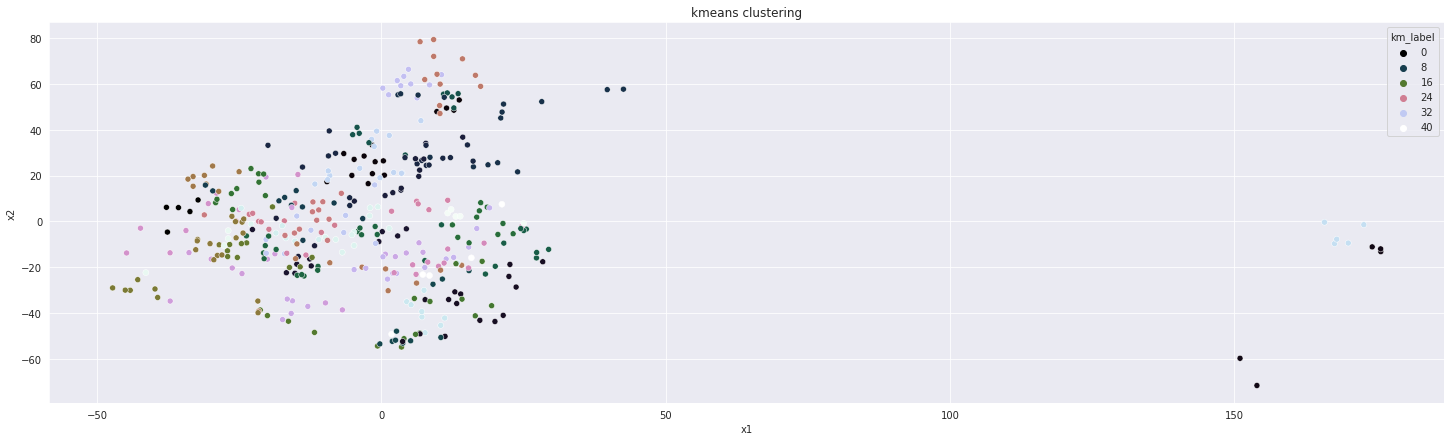

In [293]:
# kmeans plot
plt.figure(figsize=(25, 7))
ax = sns.scatterplot(data=km_df ,x='x1', y='x2', hue='km_label', palette='cubehelix')
plt.title('kmeans clustering')
plt.show()


In [294]:
#dbscan dataframe
dbscan_df=pd.DataFrame(data=pca_func(pics_array),columns=['x1','x2'])
dbscan_df['dbscan_label']=dbscan.labels_


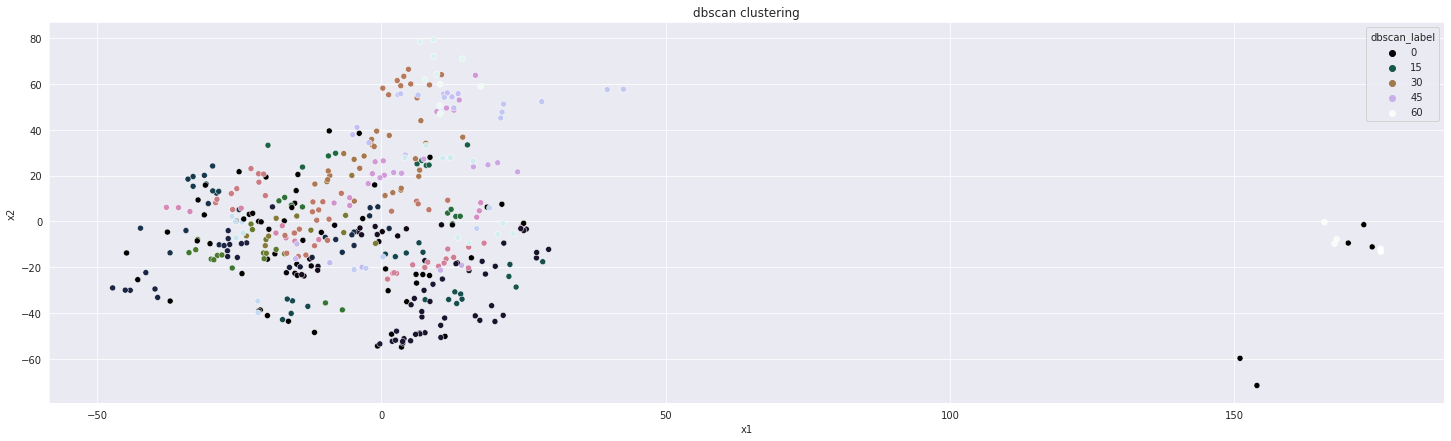

In [295]:
# dbscan plot
plt.figure(figsize=(25, 7))
ax = sns.scatterplot(data=dbscan_df ,x='x1', y='x2', hue='dbscan_label', palette='cubehelix')
plt.title('dbscan clustering')
plt.show()

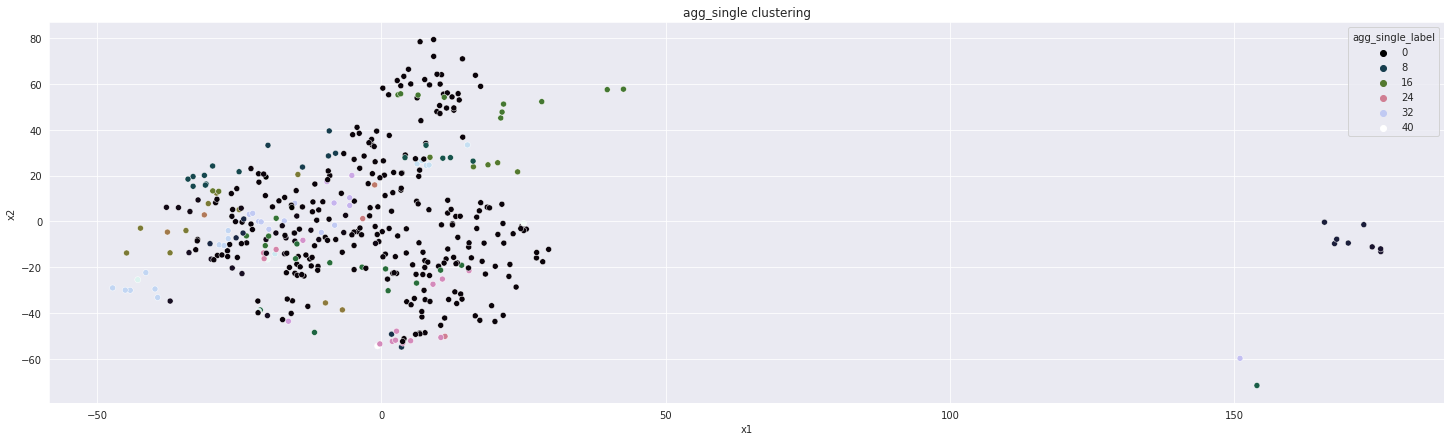

In [296]:
#agg_single dataframe and agg_single plot
agg_single_df=pd.DataFrame(data=pca_func(pics_array),columns=['x1','x2'])
agg_single_df['agg_single_label']=agg_single.labels_
plt.figure(figsize=(25, 7))
ax = sns.scatterplot(data=agg_single_df ,x='x1', y='x2', hue='agg_single_label', palette='cubehelix')
plt.title('agg_single clustering')
plt.show()

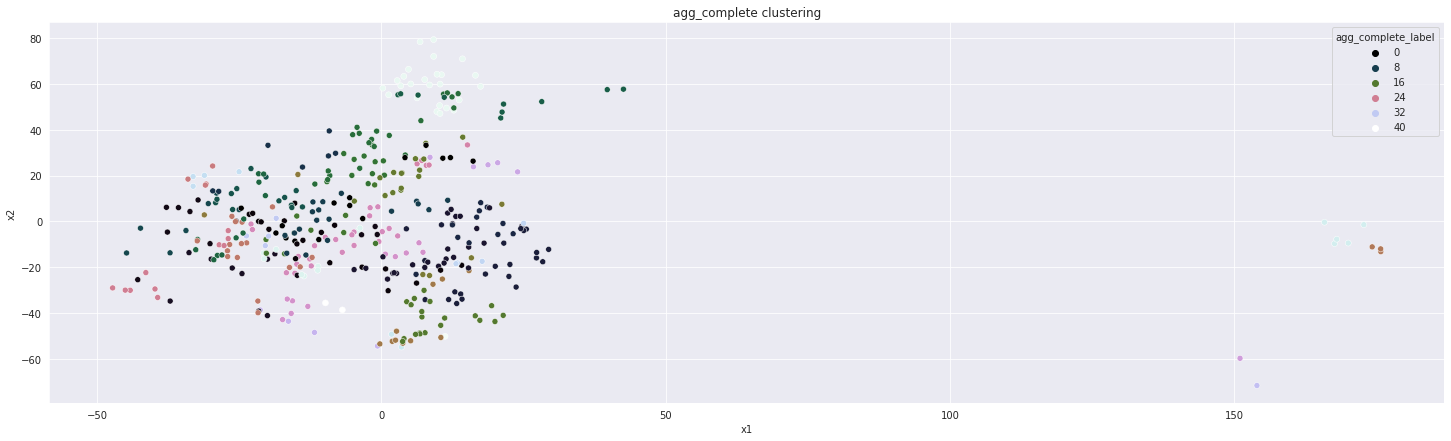

In [297]:
#agg_complete dataframe and plot agg_complete
agg_complete_df=pd.DataFrame(data=pca_func(pics_array),columns=['x1','x2'])
agg_complete_df['agg_complete_label']=agg_complete.labels_

plt.figure(figsize=(25, 7))
ax = sns.scatterplot(data=agg_complete_df ,x='x1', y='x2', hue='agg_complete_label', palette='cubehelix')
plt.title('agg_complete clustering')
plt.show()

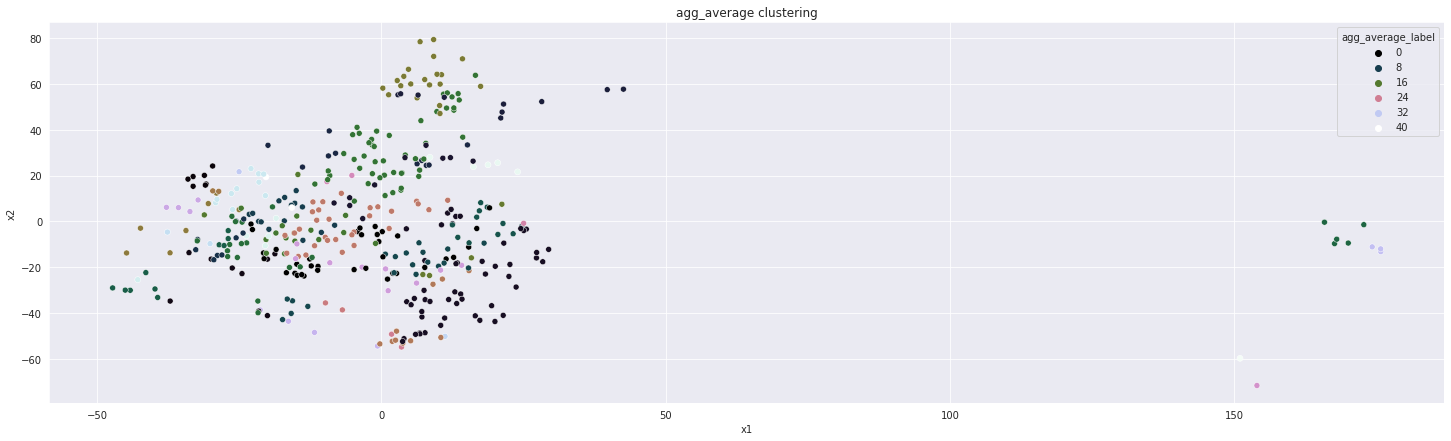

In [298]:
#agg_average dataframe and plot agg_average
agg_average_df=pd.DataFrame(data=pca_func(pics_array),columns=['x1','x2'])
agg_average_df['agg_average_label']=agg_average.labels_

plt.figure(figsize=(25, 7))
ax = sns.scatterplot(data=agg_average_df ,x='x1', y='x2', hue='agg_average_label', palette='cubehelix')
plt.title('agg_average clustering')
plt.show()

<div dir='rtl'>
<h2>
ارتقاء Agglomerative-Single Link
</h2>
</div> 
<hr/>


<div dir='rtl'>
در پلات مربوط به تک لینک دیده میشود که بخش زیادی از داده ها که همگی یک لیبل دارند که این به خاطر همان ویژگی بیشترین شباهت الگوریتم تک لینک است , در انتها بخش زیادی از داده که به هم شبیه نیستند در یک کلاستر قرار میگیرند. با استفاده از kmeanمیشود در این مرحله به الگوریتم تک لینک کمک کرد تا از کنار هم قرار دادن داده های متفاوت در یک کلاستر تا حدی جلوگیری شود و کارایی افزایش یابد. 
</div> 
</br>

<div dir='rtl'>
روش به این صورت میباشد که در ابتدا یک بار الگوریتم single link برای کلاستر بندی اجرا میشود.سپس یک مقدارthreshold بر ای واریانس کلاستر ها در نظر میگیریم.میدانیم در حالت ایده ال در هر کلاستر باید ۱۰ داده قرار بگیرد. پس کلاستر هایی که بیشتر از ۱۰ عدد داده دارند و واریانس این کلاستر بیشتر از مقدار threshold میباشد را دوباره با kmean کلاستر بندی میکنیم و لیبل های الگوریتم kmean برای این داده ها جایگیزین لیبل قبلی میشود.کلاستر هایی هم که این شروط برایشان صادق نیست لیبل داده های ان ها همان لیبل الگوریتم تک لینک میماند و تغییر نمیکند.(اگر واریانس از threshold مشخص شده بیشتر باشد به این معناست که تفاوت داده های داخل این کلاستر بیشتر از حد مطلوب ماست و تمایل داریم تا دوباره این داده ها کلاستر بندی شوند.)
</div> 
</br>
<div dir='rtl'>
  مقدار ri پیش از بهبود0.63 است اما پس از بهبود با این روش ri  برابر با مقدار0.96 است. 
</div> 
</br>

In [299]:
def get_indices(class_label,labels,img_array):  # returns all indices in a class with class_label= label 
  indices=[]
  indices=[index for index,label in enumerate(labels) if label==class_label] # find indices which 
  indices=np.array(indices)
  return indices


def get_class(class_label,labels,img_array):  # returns all data in a class with class_label label   # 1=(251, 5600)
  indices=[]
  vectors=[]
  indices=[index for index,label in enumerate(labels) if label==class_label] # find indices which 
  indices=np.array(indices)
  vectors=[img_array[i,:] for i in indices]
  vectors=np.array(vectors)
  return vectors

def calculate_class_variance(class_number,labels,img_array): # calculate variance of each class
  indices=[]
  vectors=[]
  indices=[index for index,label in enumerate(labels) if label==class_number] # find indices which 
  indices=np.array(indices)
  vectors=[img_array[i,:] for i in indices]
  vectors=np.array(vectors)
  #variance=np.var(vectors,axis=0)  #2178.066074484922  0 has 2= norm 64840.536261084395   1=102482.87257214276  40 =0
  # 32 has 10=54365.398884929564   2n has 19=86005.25000753994
  variance = np.linalg.norm(np.var(vectors,axis=0))
  return variance




In [300]:
# improve single_link:
improved_single_link_labels=[]

single= AgglomerativeClustering(n_clusters=41,linkage='single',distance_threshold=None).fit(pics_array_tmp) # implement single link
single_counter=Counter(single.labels_)

for label,count in single_counter.items():
 
  cluster=get_class(label,single.labels_,pics_array_tmp)
  # choose clusters(classes) with high variance
  if count>10 and calculate_class_variance(label,single.labels_,pics_array_tmp) >=54365 and cluster.shape[0]>=41 : 
    
    # implement k means in this clusters
    km=kmeans_template.fit(cluster) # implement kmean
    for label_km in km.labels_: improved_single_link_labels.append(label_km)   ## add km_label to improved_single_link_labels instead of single_link_labels for this clusters
  else: # for other classes we keep single-link results
    for index in get_indices(label,single.labels_,pics_array_tmp): # get index of all  data in this cluster(cluster_label=label) 
      improved_single_link_labels.append(single.labels_[index])    

improved_single_link_labels=np.array(improved_single_link_labels) #improved_single_link_labels is result of this algorithm




In [301]:
# custom ri result for  improved-single-link
improved_single_link_counter=Counter(improved_single_link_labels)
improved_single_link_ri_custom=rand_index(improved_single_link_counter,improved_single_link_labels)
improved_single_link_ri_custom

total_pairs:  83845.0
P:  2466.0
tp:  668.0
fp:  1798.0
N:  81379.0
total_same_pairs:  1845.0
fn:  1177.0
tn:  80202.0


0.9645178603375276

In [302]:
# ri by sickit for improved-single-link
improved_single_link_ri_si=rand_score(ground_labels,improved_single_link_labels)
improved_single_link_ri_si

0.9645178603375276

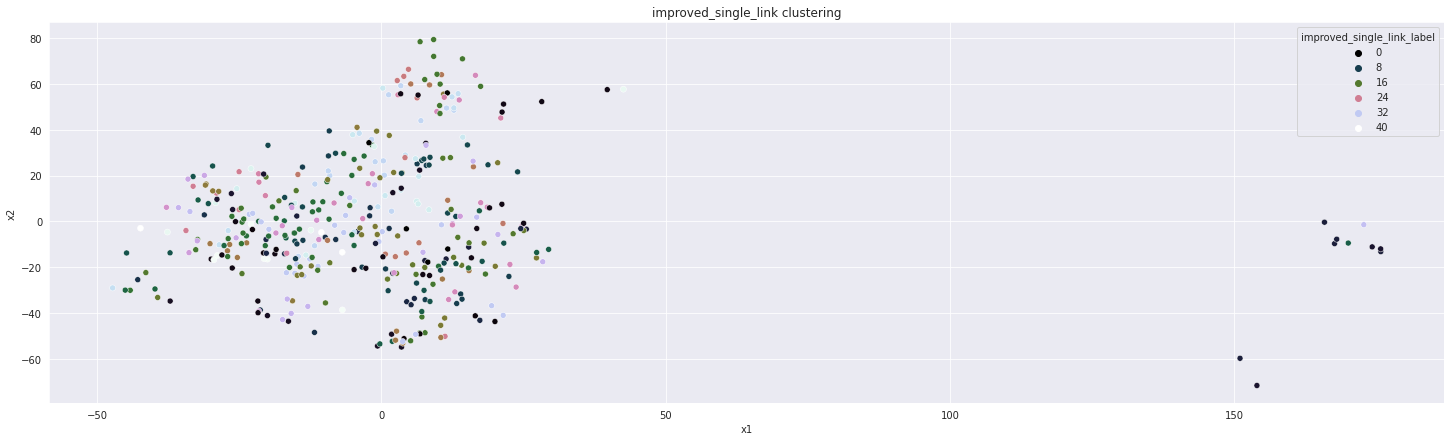

In [303]:
#improved-single-link dataframe and plot improved-single-link
improved_single_link_df=pd.DataFrame(data=pca_func(pics_array),columns=['x1','x2'])
improved_single_link_df['improved_single_link_label']=improved_single_link_labels

plt.figure(figsize=(25, 7))
ax = sns.scatterplot(data=improved_single_link_df ,x='x1', y='x2', hue='improved_single_link_label', palette='cubehelix')
plt.title('improved_single_link clustering')
plt.show()